In [1]:
import numpy as np
from math import log2
import copy

'''
This script is using all 9 features (2,3,...,10) to create a tree, which serves as a template.
Todo: you need to modify this by using the several specified features to create your own tree 
Todo: you need to do the pruning yourself
Todo: you need to get all the output including the test results.
Todo: you also need to generate the tree of such the format in the writeup: 'if (x3 <= 6) return 2 .......'
'''

with open('breast-cancer-wisconsin.data', 'r') as f:
    a = [l.strip('\n').split(',') for l in f if '?' not in l]


a = np.array(a).astype(int)   # training data

print(type(a))
print(a.shape)
print(a)

<class 'numpy.ndarray'>
(683, 11)
[[1000025       5       1 ...       1       1       2]
 [1002945       5       4 ...       2       1       2]
 [1015425       3       1 ...       1       1       2]
 ...
 [ 888820       5      10 ...      10       2       4]
 [ 897471       4       8 ...       6       1       4]
 [ 897471       4       8 ...       4       1       4]]


In [2]:
num_pos = 0
num_neg = 0
for i in range(len(a)):
    if a[i][10] == 2:
        num_neg += 1
    else:
        num_pos += 1
# open a (new) file to write
outF = open("positive_and_negative_instances.txt", "w")
outF.write(str(num_neg))
outF.write(",")
outF.write(str(num_pos))
outF.close()

In [3]:
below_b = 0
below_m = 0
above_b = 0
above_m = 0
num_neg = 0
thd = 2
for i in range(len(a)):
    #samples below the threashold
    if a[i][2] <= thd:
        if a[i][10] == 2:
            below_b += 1
        else:
            below_m += 1
    #samples above the threashold
    else:
        if a[i][10] == 2:
            above_b += 1
        else:
            above_m += 1
print(below_b, ",", above_b, ",", below_m, ",", above_m)

406 , 38 , 12 , 227


In [4]:

def entropy(data):
    count = len(data)
    p0 = sum(b[-1] == 2 for b in data) / count
    if p0 == 0 or p0 == 1: return 0
    p1 = 1 - p0
    return -p0 * log2(p0) - p1 * log2(p1)


def infogain(data, fea, threshold):  # x_fea <= threshold;  fea = 2,3,4,..., 10; threshold = 1,..., 9
    count = len(data)
    d1 = data[data[:, fea - 1] <= threshold]
    d2 = data[data[:, fea - 1] > threshold]
    if len(d1) == 0 or len(d2) == 0: return 0
    return entropy(data) - (len(d1) / count * entropy(d1) + len(d2) / count * entropy(d2))


def find_best_split(data):
    c = len(data)
    c0 = sum(b[-1] == 2 for b in data)
    if c0 == c: return (2, None)
    if c0 == 0: return (4, None)
    ig = [[infogain(data, f, t) for t in range(1, 10)] for f in [2,3,4,7,8,9]]
    ig = np.array(ig)
    max_ig = max(max(i) for i in ig)
    if max_ig == 0:
        if c0 > c - c0:
            return (2, None)
        else:
            return (4, None)
    ind = np.unravel_index(np.argmax(ig, axis=None), ig.shape)
    fea = 0
    threshold = 0
    if ind[0] == 0 or ind[0] == 1 or ind[0] == 2:
        fea = ind[0] + 2
    else:
        fea = ind[0] + 4
    threshold = ind[1] + 1
    return (fea, threshold)


def split(data, node):
    fea, threshold = node.fea, node.threshold
    d1 = data[data[:,fea-1] <= threshold]
    d2 = data[data[:,fea-1] > threshold]
    return (d1,d2)


class Node:
    def __init__(self, fea, threshold):
        self.fea = fea
        self.threshold = threshold
        self.left = None
        self.right = None

# <= threshold = 0 ~ 10
# fea = 2 ~ 10
ig = [[infogain(a, fea, t) for t in range(1,10)] for fea in [2,3,4,7,8,9]]
ig = np.array(ig)

print(ig)



[[0.11703524 0.14940719 0.22118337 0.29145718 0.35054263 0.36324318
  0.29499704 0.20772473 0.16883556]
 [0.52497259 0.58891877 0.56887349 0.48350574 0.36694691 0.28277076
  0.23500127 0.16652868 0.16342824]
 [0.47516762 0.56902539 0.55133436 0.47127319 0.36684641 0.28915248
  0.21977192 0.15805634 0.1395261 ]
 [0.49938253 0.52023775 0.50525872 0.47246546 0.44447278 0.42833044
  0.40780472 0.35279192 0.32193989]
 [0.1380979  0.32349567 0.49031098 0.39030094 0.30571097 0.28547025
  0.14214793 0.07169131 0.04555387]
 [0.37440367 0.45723842 0.38108759 0.32453048 0.27830435 0.24472868
  0.21606924 0.18527535 0.1447781 ]]


In [11]:
ind = np.unravel_index(np.argmax(ig, axis=None), ig.shape)
root_fea = 0
root_thd = 0
if ind[0] == 0 or 1 or 2:
    root_fea = ind[0] + 2
else:
    root_fea = ind[0] + 4
root_thd = ind[1] + 1
root = Node(root_fea, root_thd)

def majority_vote(data):
    num_2 = 0
    num_4 = 0
    for i in range(len(data)):
        if data[i][10] == 2:
            num_2 += 1
        else:
            num_4 += 1
    if num_2 <= num_4:
        return 4
    else:
        return 2

def create_tree(data, node):
    string = "if (x" + str(node.fea) + " <= " + str(node.threshold) + ")  "
    d1,d2 = split(data, node)
    f1, t1 = find_best_split(d1)
    if node.fea == f1 and node.threshold == t1:
        t1 = None
        f1 = majority_vote(d1)
    f2, t2 = find_best_split(d2)
    if node.fea == f2 and node.threshold == t2:
        t2 = None
        f2 = majority_vote(d2)
    if t1 == None: 
        node.left = f1
        outF.write(string + "return " + str(f1) + "\n")
    else:
        outF.write(string + "\n")
        node.left = Node(f1,t1)
        create_tree(d1, node.left)
    if t2 == None: 
        node.right = f2
        outF.write("else return " + str(f2) + "\n")
    else:
        outF.write("else" + "\n")
        node.right = Node(f2,t2)
        create_tree(d2, node.right)
    return  

outF = open("binary_decision_tree.txt", "w")
create_tree(a, root)
outF.close()


In [12]:
depth = -1

s1 = [root]
s2 = []
while s1:
    s2 = copy.deepcopy(s1)
    s1 = []
    for n in s2:
        if n != 2 and n != 4:
            print(n.fea, n.threshold)
            if n.left != None: s1 += [n.left]
            if n.right != None: s1 += [n.right]
        else:
            print(n)

    print()
    depth += 1


3 2

7 3
3 4

2 7
2 3
7 2
8 4

2
4 1
2
8 2
9 2
2 6
2 6
4

2
4
2 4
4
2
9 8
8 3
7 7
7 8
4

4
2 5
3 3
4
3 3
7 5
4 4
4
4 6
4

2
4
2
4 4
4 2
2
2 4
4
7 3
4
4
3 9

4
2 5
2
2 5
2
7 4
4
2
2
4

2
2 7
4
2
4
2

4
2



In [13]:
print(depth)

9


In [19]:
with open('breast-cancer-wisconsin.data', 'r') as f:
    a = [l.strip('\n').split(',') for l in f if '?' not in l]


a = np.array(a).astype(int)   # training data

print(type(a))
print(a.shape)
print(a)

X_train = a[:,1:10]
Y_train = a[:,10]

print(X.shape)
print(Y.shape)

<class 'numpy.ndarray'>
(683, 11)
[[1000025       5       1 ...       1       1       2]
 [1002945       5       4 ...       2       1       2]
 [1015425       3       1 ...       1       1       2]
 ...
 [ 888820       5      10 ...      10       2       4]
 [ 897471       4       8 ...       6       1       4]
 [ 897471       4       8 ...       4       1       4]]
(683, 9)
(683,)


6


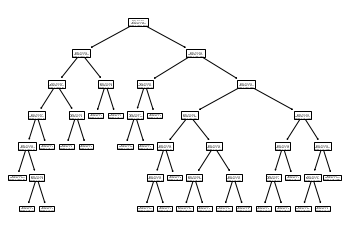

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from matplotlib import pyplot as plt

clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train, Y_train)


In [26]:
with open('test.txt', 'r') as f:
    a = [l.strip('\n').split(',') for l in f if '?' not in l]


a = np.array(a).astype(int)   # training data



X_test = a[:,1:10]

y_test = clf.predict(X_test)


# open a (new) file to write
outF = open("test_lables.txt", "w")
for i in range(len(y_test)):
    outF.write(str(y_test[i]))
    if i != len(y_test) - 1:
        outF.write(",")
outF.close()


In [40]:
with open('breast-cancer-wisconsin.data', 'r') as f:
    a = [l.strip('\n').split(',') for l in f if '?' not in l]

a = np.array(a).astype(int)   # training data


print(a)
X_train = []
for i in range(len(a)):
    features = []
    features.append(a[i][1])
    features.append(a[i][2])
    features.append(a[i][3])
    features.append(a[i][6])
    features.append(a[i][7])
    features.append(a[i][8])
    X_train.append(features)
X_train = np.array(X_train)
Y_train = a[:,10]



[[1000025       5       1 ...       1       1       2]
 [1002945       5       4 ...       2       1       2]
 [1015425       3       1 ...       1       1       2]
 ...
 [ 888820       5      10 ...      10       2       4]
 [ 897471       4       8 ...       6       1       4]
 [ 897471       4       8 ...       4       1       4]]


In [69]:
clf_prune = DecisionTreeClassifier(random_state=0, max_depth = 6)
clf_prune = clf.fit(X_train, Y_train)

print(X_train.shape)



(683, 6)


In [82]:
#This block of code attributes to : https://mljar.com/blog/extract-rules-decision-tree/
from sklearn.tree import _tree


def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            lable = 0
            if tree_.value[node][0][0] > tree_.value[node][0][1]:
                lable = 2
            else:
                lable = 4
            print("{}return {}".format(indent, lable))

    recurse(0, 0)
    
    
feature_names=["x2","x3","x4","x7","x8","x9"]
tree_to_code(clf_prune, feature_names)

if x3 <= 2.5:
    if x7 <= 5.5:
        if x2 <= 6.5:
            if x9 <= 9.0:
                if x7 <= 4.5:
                    return 2
                else:  # if x7 > 4.5
                    if x2 <= 3.5:
                        return 2
                    else:  # if x2 > 3.5
                        return 4
            else:  # if x9 > 9.0
                return 4
        else:  # if x2 > 6.5
            if x8 <= 2.5:
                return 2
            else:  # if x8 > 2.5
                return 4
    else:  # if x7 > 5.5
        if x2 <= 2.5:
            return 2
        else:  # if x2 > 2.5
            return 4
else:  # if x3 > 2.5
    if x4 <= 2.5:
        if x2 <= 5.5:
            if x7 <= 7.5:
                return 2
            else:  # if x7 > 7.5
                return 4
        else:  # if x2 > 5.5
            return 4
    else:  # if x4 > 2.5
        if x3 <= 4.5:
            if x7 <= 2.5:
                if x9 <= 7.5:
                    if x3 <= 3.5:
            

In [83]:
with open('test.txt', 'r') as f:
    a = [l.strip('\n').split(',') for l in f if '?' not in l]


a = np.array(a).astype(int)   # training data
y_test = clf.predict(X_test)
# open a (new) file to write
outF = open("test_lables_prune.txt", "w")
for i in range(len(y_test)):
    outF.write(str(y_test[i]))
    if i != len(y_test) - 1:
        outF.write(",")
outF.close()

ValueError: X has 9 features, but DecisionTreeClassifier is expecting 6 features as input.

In [84]:
x = 6
print(type(x))

<class 'int'>
